### Prompt chaining:

1. Generate a Story
2. Add a condition
    - If pass then, improve task and polish and end
    - If fail then re-generate story

In [13]:
from langchain.chat_models import init_chat_model

from langgraph.graph import StateGraph, START, END

from typing import Annotated, TypedDict, Literal
from dotenv import load_dotenv

load_dotenv()

True

In [14]:
model = init_chat_model(
    model="llama-3.1-8b-instant",  # or any other Groq model
    model_provider="groq",
    temperature=0.7,
)

In [15]:
model.invoke("Hello")

AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.010696536, 'completion_tokens_details': None, 'prompt_time': 0.001621224, 'prompt_tokens_details': None, 'queue_time': 0.005365639, 'total_time': 0.01231776}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9ca2574dca', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--18e4d834-e0bd-4789-a73f-42bcc7749011-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [16]:
class PromptChainState(TypedDict):
    query: str
    story: str
    improved_story: str
    final_polished_story: str

In [17]:
def create_story_node(state: PromptChainState) -> PromptChainState:
    initial_story = model.invoke(state["query"]).content
    return {"story": initial_story}

def validate_story(state: PromptChainState):
    current_story = state["story"]
    if "?" in current_story or "!" in current_story:
        return "Fail"
    else:
        return "Pass"

def improve_story_node(state: PromptChainState) -> PromptChainState:

    prompt = f"Enhance this story with vivid details: {state['story']}"

    improved_story = model.invoke(prompt).content
    return {"improved_story": improved_story}

def polish_story_node(state: PromptChainState) -> PromptChainState:
    prompt = f"Polish this story with unexpected twists: {state['improved_story']}"

    final_polished_story = model.invoke(prompt).content
    return {"final_polished_story": final_polished_story}

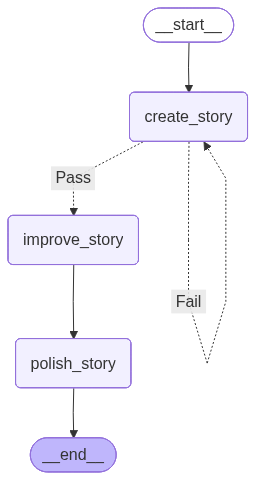

In [18]:
# Create a state graph
state_graph = StateGraph(PromptChainState)

# Add start and end states
state_graph.add_node("create_story", create_story_node)
state_graph.add_node("improve_story", improve_story_node)
state_graph.add_node("polish_story", polish_story_node)

# Add edges between states
state_graph.add_edge(START, "create_story")
state_graph.add_conditional_edges("create_story", validate_story, {"Pass": "improve_story", "Fail": "create_story"})
state_graph.add_edge("improve_story", "polish_story")
state_graph.add_edge("polish_story", END)

# Compile the graph
workflow = state_graph.compile()
workflow

In [19]:
# invoke the workflow
initial_state = {"query": "Write a story about a fictional superhero, who saves the day."}
final_state = workflow.invoke(initial_state)
final_state

{'query': 'Write a story about a fictional superhero, who saves the day.',
 'story': "In the bustling metropolis of Nova City, a legendary superhero was born. His name was Astrum, a being of unparalleled power and agility. Astrum's origin story began with a freak accident involving a meteorite that fell to Earth, imbuing him with otherworldly abilities.\n\nAstrum's real name was Ethan Thompson, a brilliant scientist who had dedicated his life to studying the mysteries of the universe. One fateful night, while working in his laboratory, a meteorite crashed through the roof, releasing a strange energy that enveloped Ethan. As the energy coursed through his body, Ethan felt an incredible transformation taking place.\n\nWhen the dust settled, Ethan awoke to find himself imbued with incredible powers. He could run at incredible velocities, leap across skyscrapers, and manipulate energy with a mere thought. He donned a sleek suit, adorned with a silver star emblem on his chest, and set out t

In [20]:
print(final_state["final_polished_story"])

In the heart of the bustling metropolis of Nova City, where towering skyscrapers pierced the sky and neon lights danced across the streets, a legendary superhero was born. His name was Astrum, a being of unparalleled power and agility, forged from the very fabric of the universe. Astrum's origin story began with a freak accident involving a meteorite that fell to Earth, imbuing him with otherworldly abilities that would redefine the boundaries of human potential.

The meteorite, a glowing fragment of a distant star, had been plummeting towards the city for eternity, its trajectory a mystery until the fateful night it crashed through the roof of Ethan Thompson's laboratory. A brilliant scientist with an insatiable thirst for knowledge, Ethan had dedicated his life to studying the mysteries of the universe, pouring over ancient texts and conducting groundbreaking experiments in his quest for understanding.

However, what the citizens of Nova City didn't know was that Ethan Thompson was n